### Install and import packages

In [1]:
# Import packages
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic

from utils import *

### Generate features data_x

In [41]:
### Generate data_x
# params
num_data = 500
num_feats = 2

data_x = stats.uniform.rvs(0, 1, size=(num_data, num_feats), random_state=12345)
# data_x = np.array([[0, 1], [1, 0]])
# print(data_x)
print(data_x.shape)

(500, 2)


### Sample weights, generate sample y from sample weights and visualize data

### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [42]:
### Generate prior and posterior samples

# num_samples 
num_samples = 1000

# weights prior distribution parameters
weights_prior_params = [
    [[0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]]],
    [[3.0, 3.0], [[1.0, 0.0], [0.0, 1.0]]]]
mix_weights = [0.5, 0.5]

# laplace approximation parameters
laplace_num_iters = 500

# laplace_init_wprior = np.random.randn(2)
# laplace_init_wprior = np.array(weights_prior_params[0][0])
init_mixtures = [0.3, 0.7]
init_mixtures = mix_weights
laplace_init_mu = \
    init_mixtures[0]*np.array(weights_prior_params[0][0]) \
    + init_mixtures[1]*np.array(weights_prior_params[1][0])

laplace_init_cov = \
    init_mixtures[0]*np.array(weights_prior_params[0][1]) \
    + init_mixtures[1]*np.array(weights_prior_params[1][1])
print(laplace_init_mu)
print(laplace_init_cov)

# generate samples A of weights prior
samples_a_weights_prior = np.concatenate([stats.multivariate_normal.rvs(
    mu, cov, size=(num_samples), random_state=1)[:,:,None] \
        for mu, cov in weights_prior_params], axis=-1)
samples_a_mixture = stats.multinomial.rvs(1, mix_weights, size=(num_samples), random_state=1)[:,None,:]
samples_a_weights_prior = np.sum(np.multiply(samples_a_weights_prior, samples_a_mixture), axis=-1)

# generate samples B of weights prior
samples_b_weights_prior = np.concatenate([stats.multivariate_normal.rvs(
    mu, cov, size=(num_samples), random_state=11)[:,:,None] \
        for mu, cov in weights_prior_params], axis=-1)
samples_b_mixture = stats.multinomial.rvs(1, mix_weights, size=(num_samples), random_state=11)[:,None,:]
samples_b_weights_prior = np.sum(np.multiply(samples_b_weights_prior, samples_b_mixture), axis=-1)

samples_a_weights_posterior = []
samples_a_weights_posterior_params = []
np.random.seed(0)
for sidx in range(num_samples):
    # for each sample w_i in A
    sample_a_weights_prior = samples_a_weights_prior[sidx].reshape(1, num_feats)
    
    # generate sample y_i from Ber(x, w_i)
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    
    # fit laplace approximation for pair (x, y_i)
    w_map, h_map = bayes_logistic.fit_bayes_logistic(
        y = sample_a_y.squeeze(-1),
        X = data_x, 
        wprior = laplace_init_mu, # initialize wprior same as prior params
        H = np.linalg.inv(laplace_init_cov),
        weights = None,
        solver = "Newton-CG",
        bounds = None,
        maxiter = laplace_num_iters
    )
    cov_map = np.linalg.inv(h_map)
    
    # sample weights' posterior p(w|x,y_i)
    sample_a_weights_posterior = stats.multivariate_normal.rvs(w_map, cov_map)
    samples_a_weights_posterior.append(sample_a_weights_posterior)  
    samples_a_weights_posterior_params.append([w_map, cov_map])

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

[1.5 1.5]
[[1. 0.]
 [0. 1.]]
(1000, 2)


### Visualize the generated prior and posterior samples

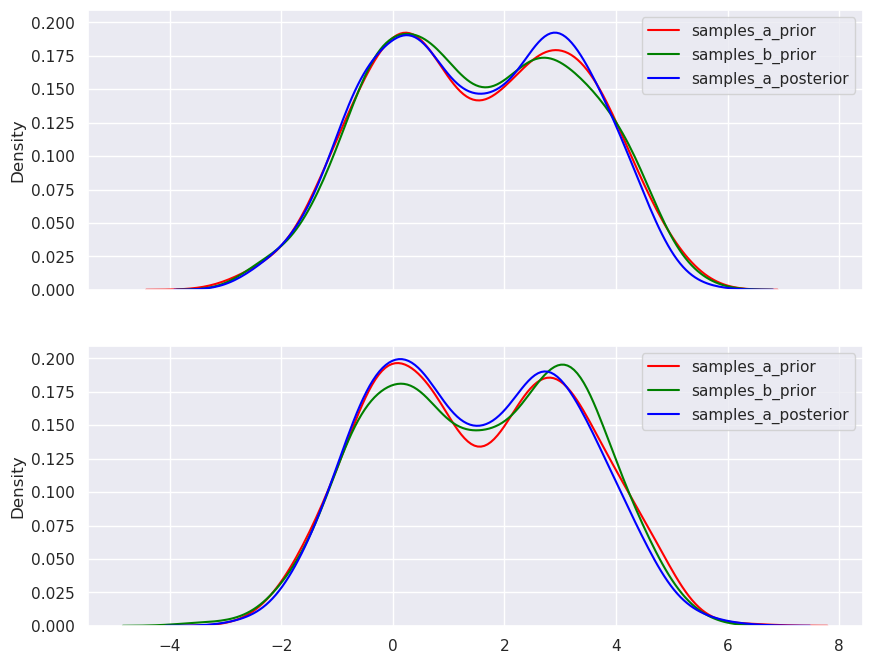

In [38]:
# Visualize the generated prior and posterior samples, individual features
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,8))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,i], fill=False, color="red", label="samples_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,i], fill=False, color="green", label="samples_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,i], fill=False, color="blue", label="samples_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

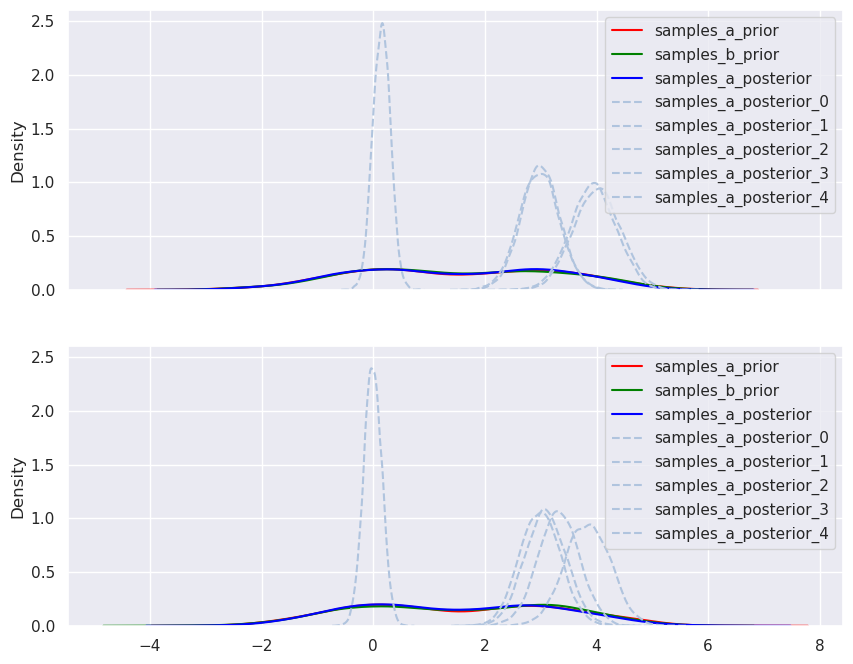

In [39]:
# Visualize the generated prior and posterior samples, individual features
nrows = 2
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,8))
axes = axes.flatten()

num_hist = 5
samples_a_weights_posterior_all = []
for j in range(num_hist):
    idx = np.random.randint(num_samples)
    w_map_j, cov_map_j = samples_a_weights_posterior_params[idx]
    samples_a_weights_posterior_j = stats.multivariate_normal.rvs(w_map_j, cov_map_j, size=(10000), random_state=j)
    samples_a_weights_posterior_all.append(samples_a_weights_posterior_j)
    
for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,i], fill=False, color="red", label="samples_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,i], fill=False, color="green", label="samples_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,i], fill=False, color="blue", label="samples_a_posterior", ax=axes[i])
    
    for j in range(num_hist):
        samples_a_weights_posterior_j = samples_a_weights_posterior_all[j]
        sns.kdeplot(samples_a_weights_posterior_j[:,i], fill=False, color="lightsteelblue", linestyle="--",
                    label=f"samples_a_posterior_{j}", ax=axes[i])
        
    axes[i].legend(loc="upper right")
plt.show()

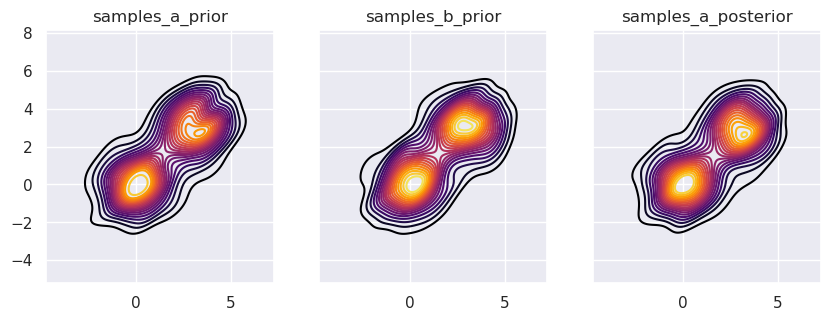

In [40]:
# Visualize the generated prior and posterior samples, pair of features
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
            cmap="inferno", fill=False, ax=axes[2])
axes[0].set_aspect(aspect="equal")
axes[1].set_aspect(aspect="equal")
axes[2].set_aspect(aspect="equal")
axes[0].set_title("samples_a_prior")
axes[1].set_title("samples_b_prior")
axes[2].set_title("samples_a_posterior")
plt.show()

### Measure the differences between the prior and samples

* Kernelized two sample test: maximum mean distance with RBF kernel
* Wasserstein distance of two samples
* Difference between the standard deviations (from true mean) of two samples

In [43]:
# Maximum mean distance with RBF kernel
mmd_rbf_prior_a_prior_b = compute_mmd_rbf(samples_a_weights_prior, samples_b_weights_prior)
mmd_rbf_posterior_a_prior_b = compute_mmd_rbf(samples_a_weights_posterior, samples_b_weights_prior)
print(f"MMD between prior a and prior b: {mmd_rbf_prior_a_prior_b:0.5f}")
print(f"MMD between posterior a and prior b: {mmd_rbf_posterior_a_prior_b:0.5f}")

MMD between prior a and prior b: 0.00151
MMD between posterior a and prior b: 0.00372


In [44]:
# Wasserstein distance with RBF kernel
wd_prior_a_prior_b = compute_wasserstein_distance(samples_a_weights_prior, samples_b_weights_prior)
wd_posterior_a_prior_b = compute_wasserstein_distance(samples_a_weights_posterior, samples_b_weights_prior)
print(f"Wasserstein distance between prior a and prior b: {wd_prior_a_prior_b:0.5f}")
print(f"Wasserstein distance between posterior a and prior b: {wd_posterior_a_prior_b:0.5f}")

Wasserstein distance between prior a and prior b: 0.19674
Wasserstein distance between posterior a and prior b: 0.24673


In [29]:
# # Difference between the standard deviations (from true mean) of two samples
# diff_std_prior_a_prior_b = compute_diff_std(samples_a_weights_prior, samples_b_weights_prior, weights_prior_params[0])
# diff_std_posterior_a_prior_b = compute_diff_std(samples_a_weights_posterior, samples_b_weights_prior, weights_prior_params[0])
# print(f"Difference standard deviations between between prior a and prior b: {diff_std_prior_a_prior_b:0.5f}")
# print(f"Difference standard deviations between posterior a and prior b: {diff_std_posterior_a_prior_b:0.5f}")